In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import numpy as np
from unravel import *

from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, BicScore, TreeSearch, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(1, 'C:/Users/paulo/code/PhD/BayesianNetwork')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyreadr
train_normal_path = 'TEP2017R/TEP_FaultFree_Training.RData'
train_faulty_path =  'TEP2017R/TEP_Faulty_Training.RData'
 
test_normal_path = 'TEP2017R/TEP_FaultFree_Testing.RData'
test_faulty_path = 'TEP2017R/TEP_Faulty_Testing.RData'
 
train_normal = pyreadr.read_r(train_normal_path)['fault_free_training']
train_faulty = pyreadr.read_r(train_faulty_path)['faulty_training']
test_normal = pyreadr.read_r(test_normal_path)['fault_free_testing']
test_faulty = pyreadr.read_r(test_faulty_path)['faulty_testing']

In [4]:
# TEP truths
faultToRoot = {1:'xmeas_4', 4:'xmeas_9', 5:'xmeas_22', 6:'xmeas_1', 11:'xmeas_21', 12:'xmeas_11', 14:'xmeas_9', 15:'xmeas_11'}
faultToVariables = {1:['xmeas_1', 'xmeas_4', 'xmeas_18', 'xmeas_21', 'xmeas_25', 'xmeas_26'],
                    14:['xmeas_9', 'xmeas_11', 'xmeas_21', 'xmeas_32']}
reactor = ['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
           'xmeas_20','xmeas_21']
seperator = ['xmeas_7', 'xmeas_20', 'xmeas_21', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_22']
stripper = ['xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_22', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 
           'xmeas_19', 'xmeas_4', 'xmeas_5']

In [3]:
# only keep continuous variables, xmeas_1 - xmeas_22
df_train_normal = train_normal[train_normal.simulationRun==1].iloc[:,3:36]
df_train_faulty = train_faulty[(train_faulty.simulationRun==1) & (train_faulty.faultNumber==12)].iloc[:,3:36]
df_train_full = pd.concat([df_train_normal, df_train_faulty], axis = 0, ignore_index=True)
kFeatures = len(df_train_normal.columns)
feature_list = list(df_train_normal.columns)

ss = StandardScaler().set_output(transform="pandas")
ss_df_train_normal = ss.fit_transform(df_train_normal)

In [8]:
algorithms = [ cdt.causality.graph.CAM() # 2 mins
             , cdt.causality.graph.CCDr()
             , cdt.causality.graph.GES()
             , cdt.causality.graph.GIES()
             , cdt.causality.graph.LiNGAM()
             , cdt.causality.graph.PC()]
nalgo = len(algorithms)
algo_edges = {}
for i in range(nalgo):
    algo1 = str(algorithms[i]).split(sep='.')[3]
    print("algorithm:", algo1)
    start = time.time()
    g = algorithms[i].predict(df_train_normal)
    algo_edges[algo1] = list(g.edges())
    end = time.time()
    print("time elpased:", end - start)
    #plt.figure()
    #plt.title(algo1)
    #nx.draw_networkx(g, with_labels=True)
    #gplint(g, fname = algo1 + ".html")
plt.show()

algorithm: CAM
time elpased: 54.10973882675171
algorithm: CCDr
time elpased: 1.6653008460998535
algorithm: GES
time elpased: 0.9816610813140869
algorithm: GIES
time elpased: 0.9879190921783447
algorithm: LiNGAM
time elpased: 1.2820913791656494
algorithm: PC
time elpased: 2.3707122802734375


In [13]:
print(util.convert_edges_to_boolTable(algorithms[i]))

In [6]:
def displayComponentStatistics(data, pca_model, kComponents):
    name = list(df_train_normal.columns)
    score = abs(pca.components_)
    print(sorted(zip(score[0], name), reverse=True)[:kComponents])
    print(sorted(zip(score[1], name), reverse=True)[:kComponents])
    print(np.sum(pca.explained_variance_ratio_[:kComponents]))

def hotelling_t_squared(data, pca_model):
    # Transform data into principal component space
    transformed_data = pca_model.transform(data)
    
    # Calculate centroid in principal component space
    centroid = np.mean(transformed_data, axis=0)
    
    # Calculate Mahalanobis distance (T^2 score) for each sample
    t_squared_scores = np.sum((transformed_data - centroid)**2 / pca_model.explained_variance_, axis=1)
    return t_squared_scores

#doesn't work
def calculate_cdc_score(data, pca_model, faulty_indices):
    # Transform data into principal component space
    transformed_data = pca_model.transform(data)
    
    # Extract relevant components and covariance matrix
    principal_components = pca_model.components_
    covariance_matrix = np.cov(transformed_data.T)
    
    # Calculate CDC scores for each faulty instance and each variable
    cdc_scores = []
    for idx in faulty_indices:
        t_squared_instance = transformed_data[idx]
        cdc_score_instance = np.zeros(len(principal_components))
        for i in range(len(principal_components)):
            contribution = np.dot(principal_components[i], np.dot(np.linalg.inv(covariance_matrix), principal_components[i].T))
            normalized_contribution = contribution / np.sum(contribution)
            cdc_score_instance[i] = normalized_contribution * t_squared_instance[i] ** 2
        cdc_scores.append(cdc_score_instance)
    return np.array(cdc_scores)

def top_ten_vars(df, pca_model):
    name = list(df.columns)
    score = abs(pca_model.components_)
    variables = set()
    for i in sorted(zip(score[0], name), reverse=True)[:5]:
        variables.add(i[1])
    for i in sorted(zip(score[1], name), reverse=True)[:5]:
        variables.add(i[1])
    variables = list(variables)
    return variables

# Freedman-Diaconis rule
def equal_width_bin(df):
    # df = df[df.simulationRun==1].iloc[:,3:25]
    # normalize dataframe
    df = (df - df.mean())/df.std()
    n = df.shape[0]
    for col in list(df.columns):
        c = df[col]
        num_bins = math.ceil((c.max() - c.min()) / (2 * (c.quantile(0.75) - c.quantile(0.25)) / (n**(1/3))))
        df[col] = pd.cut(df[col], bins=num_bins, labels=False)
    return df

#mean contribution threshold
def MCTvariables(contributions, t2_scores):
    # contributions: m x n, where m is number of samples, n is number of variables
    n = len(contributions[0])
    m = len(contributions)
    minFrequency = m * 0.05
    count = [0]*n
    variables = []
    for i in range(m):
        # change 50
        if t2_scores[i] > 50:
            contribution = contributions[i]
            mean = sum(contribution)/n
            for j in range(n):
                if contribution[j] > mean:
                    count[j] += 1
    for i in range(n):
        if count[i] > minFrequency:
            variables.append(i)
    return variables

  0%|          | 0/5 [00:00<?, ?it/s]

4


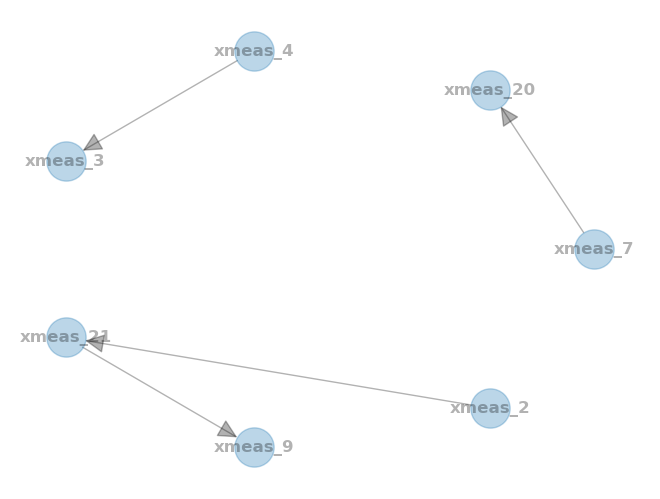

In [32]:
est = PC(equal_width_bin(df_train_normal.loc[:, reactor]))
model_chi = est.estimate(significance_level=0.05)
print(len(model_chi.edges()))
nx.draw_circular(
    model_chi, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

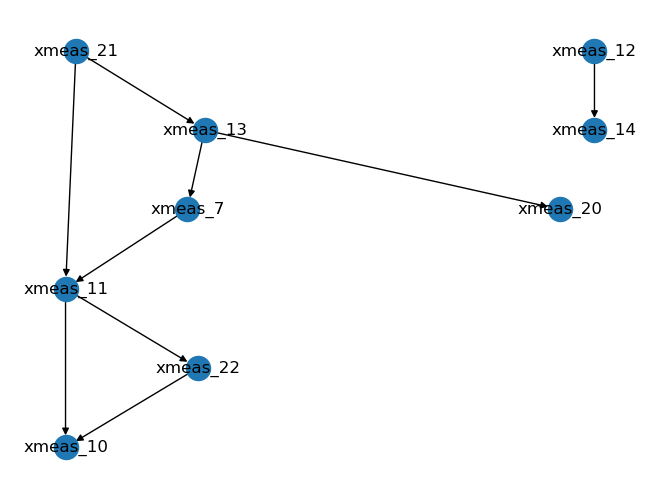

  0%|          | 0/100 [00:00<?, ?it/s]

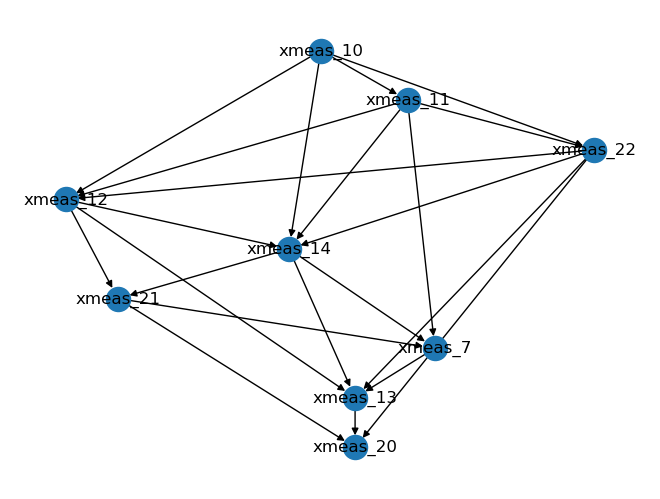

  0%|          | 0/100 [00:00<?, ?it/s]

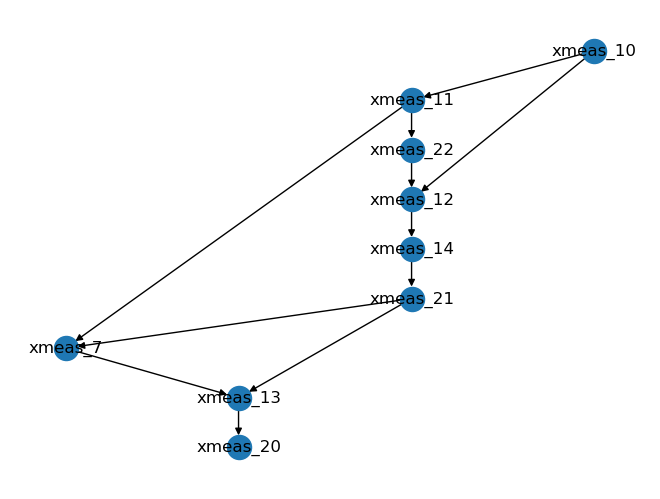

  0%|          | 0/100 [00:00<?, ?it/s]

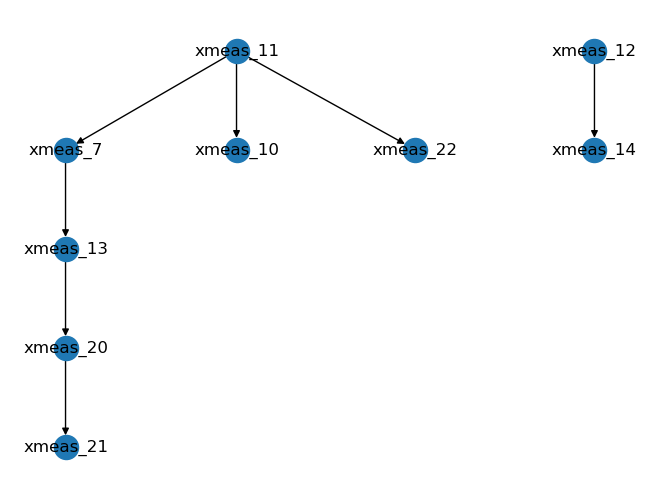

  0%|          | 0/100 [00:00<?, ?it/s]

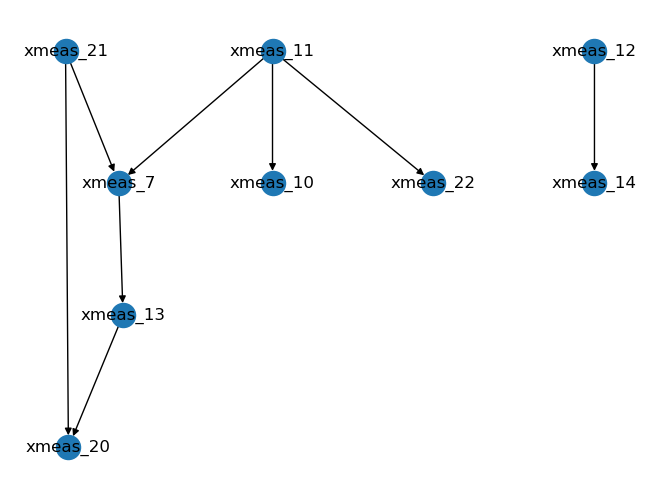

In [70]:
fault = alarm_df(df_train_normal, df_train_faulty).loc[:, seperator]

# learn graph structure
est = HillClimbSearch(fault)
# k2score, bdeuscore, bdsscore, bicscore, aicscore
for score in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    best_model = est.estimate(max_iter=100, scoring_method=score, max_indegree=None)
    write_dot(best_model,'test.dot')
    pos =graphviz_layout(best_model, prog='dot')
    nx.draw(best_model, pos, with_labels=True, arrows=True)
    plt.show()

In [45]:
"""
# PC estimator, outputs a very low number of variables
from pgmpy.estimators import PC
est = PC(equal_width_bin(df_train_faulty.iloc[:, variables]))
# 0.001 has 2 edges df_train_normal[variables]
model_chi = est.estimate(significance_level=0.01)
print(len(model_chi.edges()))
nx.draw_circular(
    model_chi, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

# Funtion to evaluate the learned model structures. Not useful since we don't know the actual structure.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_array(
        estimated_model.to_undirected(), nodelist=nodes, weight=None
    )
    true_adj = nx.to_numpy_array(
        true_model.to_undirected(), nodelist=nodes, weight=None
    )

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)
est = PC(data=df_train_normal)
estimated_model = est.estimate(variant="stable", max_cond_vars=4)
get_f1_score(estimated_model, model)
"""

'\n# Funtion to evaluate the learned model structures. Not useful since we don\'t know the actual structure.\ndef get_f1_score(estimated_model, true_model):\n    nodes = estimated_model.nodes()\n    est_adj = nx.to_numpy_array(\n        estimated_model.to_undirected(), nodelist=nodes, weight=None\n    )\n    true_adj = nx.to_numpy_array(\n        true_model.to_undirected(), nodelist=nodes, weight=None\n    )\n\n    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))\n    print("F1-score for the model skeleton: ", f1)\nest = PC(data=df_train_normal)\nestimated_model = est.estimate(variant="stable", max_cond_vars=4)\nget_f1_score(estimated_model, model)\n'

In [7]:
from pgmpy.estimators import BayesianEstimator

# there are many choices of parametrization, here is one example
model = BayesianNetwork(edges())
model.fit(
    df_train_normal, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts=0.1
)
model.get_cpds()

NameError: name 'dag' is not defined

In [52]:
# Analyse distribution of variables, e.g. normally distributed with normality test like Anderson-Darling Test
from scipy.stats import anderson

# Create header for tabular output
print(f"{'DISTRIBUTION':<15}{'%sig':<10}{'stat':<12}{'crit-val':<10}"
      f"{'result':<10}\n")

# Loop through all continuous random variables and test them
for var in df_train_normal.columns:
    test = anderson(df_train_normal[var])
    # Loop through test results and unpack the sig.levels and crit-vals
    for i in range(len(test.critical_values)):
        sig_lev, cv = test.significance_level[i], test.critical_values[i]
        # Check if test.stat is < crit-val
        result = 'Fail to reject' if test.statistic < cv else 'Reject'
        # Print results in tabular format
        print(f"{var:<15}{sig_lev:<10}{test.statistic:<12.3f}{cv:<10}"
              f"{result:<10}")  
        if i is 4:
            print('\n')

DISTRIBUTION   %sig      stat        crit-val  result    

xmeas_1        15.0      0.661       0.571     Reject    
xmeas_1        10.0      0.661       0.651     Reject    
xmeas_1        5.0       0.661       0.781     Fail to reject
xmeas_1        2.5       0.661       0.911     Fail to reject
xmeas_1        1.0       0.661       1.083     Fail to reject


xmeas_2        15.0      0.634       0.571     Reject    
xmeas_2        10.0      0.634       0.651     Fail to reject
xmeas_2        5.0       0.634       0.781     Fail to reject
xmeas_2        2.5       0.634       0.911     Fail to reject
xmeas_2        1.0       0.634       1.083     Fail to reject


xmeas_3        15.0      0.828       0.571     Reject    
xmeas_3        10.0      0.828       0.651     Reject    
xmeas_3        5.0       0.828       0.781     Reject    
xmeas_3        2.5       0.828       0.911     Fail to reject
xmeas_3        1.0       0.828       1.083     Fail to reject


xmeas_4        15.0      0.33

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\paulo\AppData\Local\Temp\ipykernel_6696\859025840.py:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 4:


Success=0.25000000000000006
Failure=0.75
